Runs a quick classifier on our cell images

In [1]:
import DataProvider as DP
import importlib
# import  random
import numpy as np
import os
import torch




myseed = 0
DP = importlib.reload(DP)


np.random.seed(myseed)



image_dir = '/root/images/2016_11_08_Nuc_Cell_Seg_8_cell_lines_V22/processed_aligned/2D/'

opts = {}
opts['out_size'] = [32, 32]
opts['verbose'] = True

data_path = './data_64x64.pyt'

if os.path.exists(data_path):
    dp = torch.load(data_path)
else:
    dp = DP.DataProvider(image_dir, opts)
    torch.save(dp, data_path)

inds = [1,2]
images = dp.get_images(inds, 'train')
labels = dp.get_labels(inds, 'train')

print(images.size())
print(labels)
nlabels = dp.get_n_classes()

print('nlabels: ' + str(nlabels))



torch.Size([2, 3, 64, 64])

 4
 5
[torch.LongTensor of size 2]

nlabels: 8


In [2]:
dims = list(dp.images[0].size())
dims.insert(0, len(inds))

images = torch.zeros(tuple(dims))

c = 0
for i in inds:
    images[c] = dp.images[dp.data['train']['inds'][i]].clone()
    c += 1

In [3]:
# dp.images[dp.data['train']['inds'][i]].size()
# images = torch.FloatTensor(dims[:])
print(images.size())

print(dims)

torch.Size([2, 3, 64, 64])
[2, 3, 64, 64]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def imshow(img):
#     img = img / 2 + 0.5 # unnormalize

    img = img.numpy()
    img = np.transpose(img, [1,2,0])
    print(np.max(img))
    plt.imshow(img)

torch.Size([1, 3, 64, 64])
0.509804
0.509804


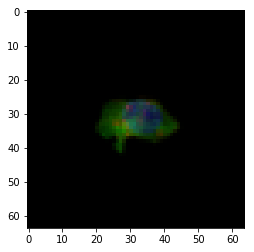

In [5]:
img = dp.get_images([100], 'train')
print(img.size())
print(np.max(img[0].numpy()))
imshow(img[0])

In [16]:
from torch import nn
from torch.autograd import Variable

dat = Variable(torch.rand(1, 1, 16, 16))
print(dat.data.size())

layer = nn.Conv2d(1, 6, 5, 1, 2)
dat_out = layer(dat)

print(dat_out.data.size())



torch.Size([1, 1, 16, 16])
torch.Size([1, 6, 16, 16])


In [23]:
from torch import nn
import torch.nn.functional as F
import pdb

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1, 2)
        self.conv3 = nn.Conv2d(16, 32, 5, 1, 2)
        
        self.pool  = nn.MaxPool2d(2,2)     
        
        self.fc1   = nn.Linear(32*8*8, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)        
        self.bn4 = nn.BatchNorm1d(120)
        self.bn5 = nn.BatchNorm1d(84)        
        self.bn6 = nn.BatchNorm1d(10)        


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))        
        x = x.view(-1, 32*8*8)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.bn6(self.fc3(x))
        return x

net = Net()

In [30]:
import torch.optim as optim
from torch.autograd import Variable

criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.Adam(net.parameters(), lr=0.001)


batchsize = 64

gpu_id = 1
net.cuda(gpu_id)


for epoch in range(100): # loop over the dataset multiple times

    rand_inds = np.random.permutation(dp.get_n_train())
    inds = (rand_inds[i:i+batchsize] for i in range(0, len(rand_inds), batchsize))
    
    running_loss = 0.0
    c = 0
    for i in inds:
        c += 1
        
        inputs = dp.get_images(i, 'train')
        labels = dp.get_labels(i, 'train', 'index')
        
        # wrap them in Variable
        inputs, labels = Variable(inputs).cuda(gpu_id), Variable(labels).cuda(gpu_id)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()        
        optimizer.step()
        
#         print(loss.data[0])
        
        # print statistics
        running_loss += loss.data[0]
        
    print('[%d] loss: %.3f' % (epoch+1, running_loss / c))
print('Finished Training')

[1] loss: 0.118
[2] loss: 0.251
[3] loss: 0.222
[4] loss: 0.166
[5] loss: 0.231
[6] loss: 0.228
[7] loss: 0.213
[8] loss: 0.074
[9] loss: 0.105
[10] loss: 0.076
[11] loss: 0.117
[12] loss: 0.081
[13] loss: 0.068
[14] loss: 0.071
[15] loss: 0.195
[16] loss: 0.068
[17] loss: 0.053
[18] loss: 0.056
[19] loss: 0.067
[20] loss: 0.186
[21] loss: 0.091
[22] loss: 0.099
[23] loss: 0.186
[24] loss: 0.058
[25] loss: 0.184
[26] loss: 0.099
[27] loss: 0.079
[28] loss: 0.187
[29] loss: 0.197
[30] loss: 0.186
[31] loss: 0.097
[32] loss: 0.169
[33] loss: 0.059
[34] loss: 0.070
[35] loss: 0.086
[36] loss: 0.195
[37] loss: 0.077
[38] loss: 0.084
[39] loss: 0.063
[40] loss: 0.083
[41] loss: 0.056
[42] loss: 0.059
[43] loss: 0.048
[44] loss: 0.080
[45] loss: 0.044
[46] loss: 0.072
[47] loss: 0.165
[48] loss: 0.162
[49] loss: 0.039
[50] loss: 0.078
[51] loss: 0.072
[52] loss: 0.093
[53] loss: 0.167
[54] loss: 0.173
[55] loss: 0.033
[56] loss: 0.136
[57] loss: 0.190
[58] loss: 0.167
[59] loss: 0.128
[60] l

In [28]:
inds = [i for i in range(0,dp.get_n_test())]
images = dp.get_images(inds, 'test').cuda(gpu_id)
labels = dp.get_labels(inds, 'test')
outputs = net(Variable(images))

_, predicted = torch.max(outputs.data, 1)

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

print(cm)

[[10  0  0  1  0  0  0  0]
 [ 1 10  1  0  0  0  1  1]
 [ 0  4  4  0  0  0  0  1]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0 11  1  0  0]
 [ 1  1  0  0  0 13  0  0]
 [ 0  0  1  0  0  0  5  0]
 [ 3  0  1  0  0  1  0 16]]


In [7]:
import torch.optim as optim
from torch.autograd import Variable

criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.Adam(net.parameters(), lr=0.0001)


batchsize = 64

gpu_id = 1
net.cuda(gpu_id)


rand_inds = np.random.permutation(dp.get_n_train())
inds = (rand_inds[i:i+batchsize] for i in range(0, len(rand_inds), batchsize))
    

[array([1109,  342,  381,  511, 1605,  853,  685,  425,  539,  557, 1491,
         271,  516, 1103,  520,  522,  229, 1170, 1576, 1399,  899, 1088,
         722,  240, 1648,   76, 1226,  987,  792, 1594,  107,  489,  576,
        1073, 1015, 1393, 1124,  461,  593,  360,  438,  621,   80, 1129,
         175, 1601,  481,  361,  725, 1479, 1178,  546,  883, 1276,   14,
          53, 1122, 1149,  740, 1583,  877, 1532,  708,  943]),
 array([1553, 1238,   18, 1002,  124, 1621,  299,  984,  308,  914, 1183,
         513,  820,  310, 1089, 1034, 1317, 1302,  187,  390, 1154,  414,
         655, 1321, 1341, 1179,  905, 1595,  789, 1044,  969,  826,  651,
        1264, 1481, 1014,  916,  532,  530,  536,  408, 1655,  658, 1074,
        1598,  844,  278,  217, 1259, 1116, 1423,    5,   58, 1575, 1072,
        1057,  432,  249,   34, 1169, 1619,  191,  688, 1054]),
 array([ 609,  161, 1125, 1632,  788,  980, 1287,  452,   19, 1246, 1268,
          54, 1450,  771, 1490,  427, 1625,    9,  378,  1